In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name = "/content/lgg-mri-segmentation.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:

import kagglehub
mateuszbuda_lgg_mri_segmentation_path = kagglehub.dataset_download('mateuszbuda/lgg-mri-segmentation')

print('Data source import complete.')

Data source import complete.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob  # Filename pattern matching
import random
import cv2  # Computer vision
from PIL import Image  # Image processing

import torch
import torchvision  # Computer vision tools
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Neural network functions
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as tt  # Image transformations
import albumentations as A  # Image augmentations
from tqdm import tqdm  # Progress bar
from mpl_toolkits.axes_grid1 import ImageGrid  # Image grid layout
from torch.utils.data import DataLoader  # Data loading
from torchvision.utils import make_grid  # Create image grids
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def set_seed(seed=0):  # Function to set random seed for reproducibility
    torch.backends.cudnn.deterministic = True # ensures deterministic behavior in PyTorch when using CUDA
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)  #
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

In [ ]:
ROOT_PATH = 'lgg-mri-segmentation/kaggle_3m/'

# Using glob.glob to collect paths of all mask files in subdirectories
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

# Defining a function diagnosis(mask_path) that returns 1
#if the maximum pixel value in the mask image (read using cv2) is greater than 0
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,1
1,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,0
2,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,1
3,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,1
4,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19...,1
...,...,...,...
3924,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19...,1
3925,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19...,1
3926,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19...,1
3927,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19...,1


In [ ]:
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

Total of No Tumor: 2556
Total of Tumor: 1373


In [ ]:
# Splitting the dataset into training data (train_df), validation data (val_df),
#and test data (test_df) with specified proportions.
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


(-0.5, 1279.5, 255.5, -0.5)

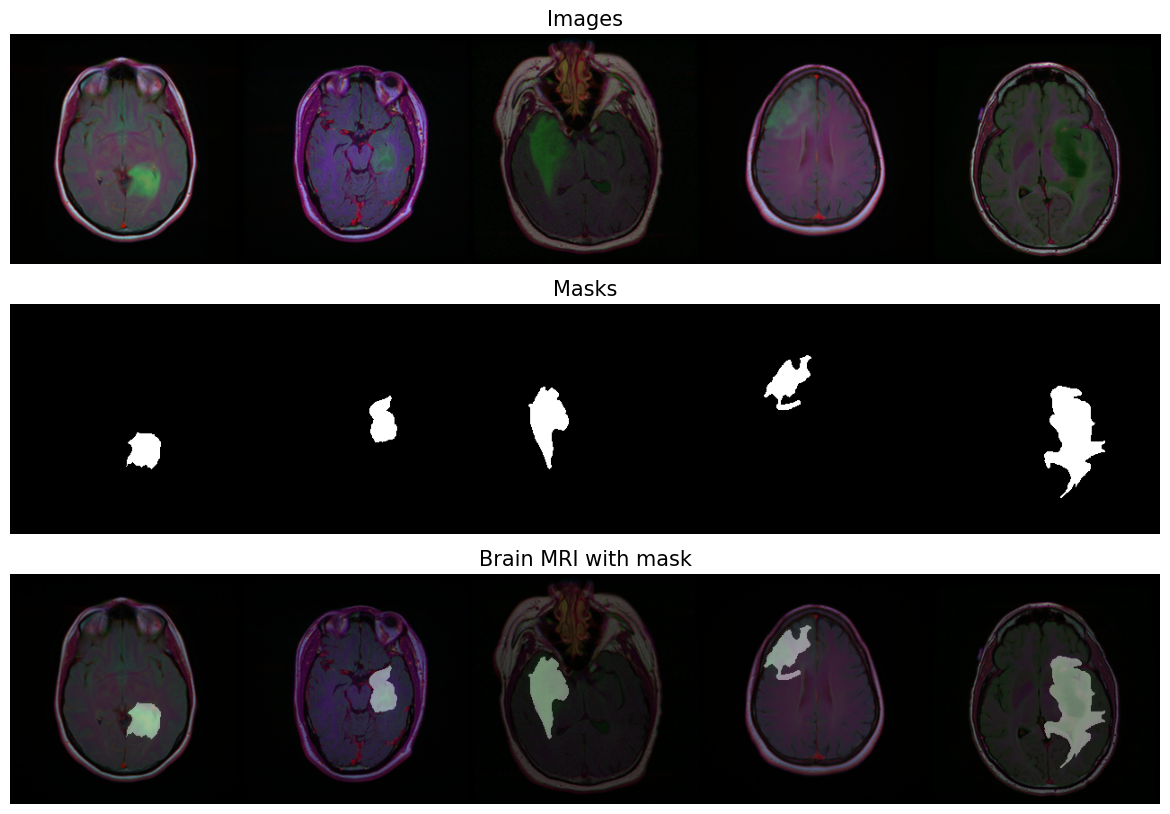

In [ ]:
set_seed()
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

In [ ]:
# Custom PyTorch Dataset class for loading images and masks from a DataFrame.
class BrainDataset(data.Dataset): #It allows you to efficiently load images and masks in batches, which is crucial for training a neural network.
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1)) #Converts the image from the standard shape of (height, width, channels) to (channels, height, width), which is the format expected by PyTorch.
        image = torch.from_numpy(image).type(torch.float32) #Converts the NumPy array to a PyTorch tensor of type float32.
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image) #Normalizes the image tensor using mean and standard deviation values commonly used for pretrained models (e.g., models trained on ImageNet). This step adjusts the pixel intensity distribution, which is crucial for consistent training.
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1)) # The mask is expanded to add an extra dimension (since it's grayscale) and transposed into the (channels, height, width) format.
        mask = torch.from_numpy(mask).type(torch.float32) #Converts the mask from a NumPy array to a PyTorch tensor of type float32.

        return image, mask

In [ ]:
# Define transformations for training, validation, and testing datasets using Albumentations library.
# Here, A.Compose() and the transformations (A.Resize(), A.HorizontalFlip(), etc.) are from the Albumentations library.
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels # The p=1.0 means this transformation will always be applied (100% probability).
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),  # Apply vertical flip with 50% probability
    A.RandomRotate90(p=0.5),  # Rotate randomly by 90 degrees with 50% probability
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  # Randomly shift, scale, and rotate
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability (for data augmentation)
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
])

In [ ]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [ ]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}') # This line prints the size of the dataset by calling len(dataset), which tells how many data points (image-mask pairs) are present in the dataset
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [ ]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-20 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-14 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



In [ ]:
batch_size = 100

# Set seed for reproducibility in random operations.
set_seed()
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
set_seed()
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2, # Specifies the number of parallel processes that will load the data. Having multiple workers can speed up the data loading process.
                    pin_memory=True) # Ensures that the data is loaded into page-locked memory, which can make it faster to transfer data to the GPU, improving training efficiency.
test_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)


In [ ]:
# Fetch a batch of data (images and masks) from the training DataLoader (`train_dl`).
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([100, 3, 128, 128])
torch.Size([100, 1, 128, 128])


In [ ]:
# Defines the DoubleConv class, consisting of three consecutive
# convolutional layers each followed by BatchNorm and ReLU.

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 3"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.triple_conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),

            # Second convolutional layer
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),

            # Third convolutional layer (extra layer)
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.triple_conv(x)

# Defines the Down class, which performs downscaling using MaxPool
# followed by TripleConv.
class Down(nn.Module):
    """Downscaling with maxpool then triple conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

# Defines the Up class, which performs upscaling followed by TripleConv.
class Up(nn.Module):
    """Upscaling then triple conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Defines the OutConv class, which performs a 1x1 convolution followed by Sigmoid activation.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)


In [ ]:
# Defines the UNet class, a convolutional neural network architecture
# for semantic segmentation.
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

    # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)

    # Decoder (upsampling path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

    # Output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):

    # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

    # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

    # Final output
        logits = self.outc(x)
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3, 1).to(device)

# Perform a forward pass through the model with a random input tensor
#of shape (1, 3, 128, 128), moved to the specified device (GPU or CPU).
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)

torch.Size([1, 1, 128, 128])


In [ ]:
# Function to calculate the Dice coefficient metric between prediction and ground truth.
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth.
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss.
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

In [ ]:
# Function to perform the training loop for the model.
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []

    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

# Convert outputs to numpy array for post-processing
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_dices, train_losses

In [ ]:
# Function to perform evaluation loop for the model.
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

    # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss

In [ ]:
# Function to train the model and evaluate on validation data across epochs.
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice,val_mean_dice))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

In [ ]:
# Define the optimizer with Adam optimizer and initial learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler with ReduceLROnPlateau, monitoring 'max' validation metric, and patience of 3 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Number of epochs for training
num_epochs = 50

In [ ]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

In [ ]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="r")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="c")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

# Example usage to plot Dice coefficient history for a UNet model
plot_dice_history('U-NET Coefficient History', train_dice_history, val_dice_history, num_epochs)

In [ ]:
%%time
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

In [ ]:
# a sample from the test set with diagnosis label 1 and resize image and mask
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))


pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[2].imshow(pred)
ax[2].set_title("Prediction")

plt.show()

In [ ]:
torch.save(model.state_dict(), 'brain-mri-unet.pth')